#### Matrix factorization 2
Use small movie/user matrix predict missing ratings

See https://temugeb.github.io/tensorflow/python/svd/2021/02/04/Funk-SVD-recommender-p2.html

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
rating_data = np.loadtxt("datasets/ratings_small.csv", delimiter = "," , skiprows = 1)
users = rating_data[:,0]
movies = rating_data[:,1]
ratings = rating_data[:,2]
users = users.astype('int32')
movies = movies.astype('int32')
uniques = [np.unique(users).shape[0], np.unique(movies).shape[0]]

print(f"Data length {len(rating_data)}, Uniques users/movies {uniques}")

Data length 100004, Uniques users/movies [671, 9066]


In [8]:
# Reindex movies
m_uniques = np.unique(movies)
 
#count the number of times that movie appears 
m_occurances = [] 
for m in m_uniques:
    occ = np.count_nonzero(movies == m)
    m_occurances.append(occ)
m_occurances = np.array(m_occurances)

sort_indices = np.argsort(m_occurances)

# The unique movie ids in descending order
m_uniques_occ_sorted = m_uniques[sort_indices]
m_uniques_occ_sorted = m_uniques_occ_sorted[::-1]
m_uniques_occ_sorted = np.array(m_uniques_occ_sorted)
# print(m_uniques_occ_sorted)

print(m_uniques_occ_sorted)
print(np.where(m_uniques_occ_sorted == 318)[0][0])

[   356    296    318 ...  26480  26485 163949]
2


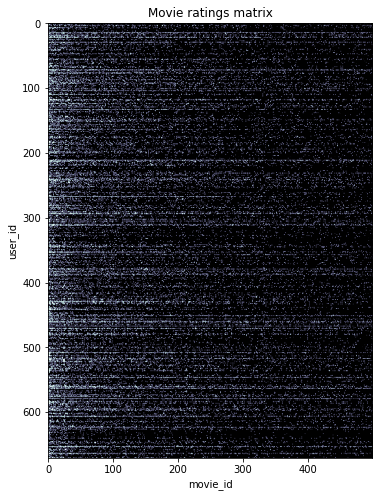

In [9]:
# Generate ratings matrix
M = np.zeros((uniques[0], uniques[1]))
mask = np.zeros(M.shape)
for u, m, r in zip(users, movies, ratings):
    # user ID starts from 1.
    M[u - 1, np.where(m_uniques_occ_sorted == m)[0][0]] = r
    mask[u - 1, np.where(m_uniques_occ_sorted == m)[0][0]] = 1
     
plt.figure(figsize=(10,8))
plt.imshow(M[:,:500], cmap='bone')
plt.xlabel('movie_id')
plt.ylabel('user_id')
plt.title('Movie ratings matrix')
plt.show()

In [10]:
# Create a validation set
val_count = 5000
_is = np.random.randint(0, len(users), val_count)
 
val_mask = np.zeros(M.shape)
for i in _is:
    _user = users[i] - 1
    _movie = np.where(m_uniques_occ_sorted == movies[i])[0][0]
    val_mask[_user, _movie] = 1
     
print(np.sum(val_mask))

4878.0


In [11]:
def early_stopping(losses, patience = 5):
     
    if len(losses) <= patience + 1:
        return False
     
    avg_loss = np.mean(losses[-1 - patience:-1])
     
    if avg_loss - losses[-1] < 0.01*avg_loss:
        return True
     
    return False

In [12]:
cutoff = 9000
M = tf.constant(M[:,:cutoff], dtype = 'float32')
val_mask = tf.constant(val_mask[:,:cutoff], dtype = 'float32')
train_mask = tf.constant((mask[:,:cutoff] - val_mask[:,:cutoff]), dtype = 'float32')

0:00:00.221388 tf.Tensor(23.975801, shape=(), dtype=float32) tf.Tensor(24.079231, shape=(), dtype=float32) 0
0:00:13.178755 tf.Tensor(17.958035, shape=(), dtype=float32) tf.Tensor(20.312897, shape=(), dtype=float32) 100
0:00:26.502298 tf.Tensor(14.05941, shape=(), dtype=float32) tf.Tensor(17.628147, shape=(), dtype=float32) 200
0:00:39.609918 tf.Tensor(9.140679, shape=(), dtype=float32) tf.Tensor(13.089561, shape=(), dtype=float32) 300
0:00:52.767795 tf.Tensor(4.843263, shape=(), dtype=float32) tf.Tensor(8.504141, shape=(), dtype=float32) 400
0:01:06.215661 tf.Tensor(2.7754593, shape=(), dtype=float32) tf.Tensor(6.020876, shape=(), dtype=float32) 500
0:01:20.614960 tf.Tensor(1.8606632, shape=(), dtype=float32) tf.Tensor(4.753918, shape=(), dtype=float32) 600
0:01:33.256950 tf.Tensor(1.3934702, shape=(), dtype=float32) tf.Tensor(4.017206, shape=(), dtype=float32) 700
0:01:45.836402 tf.Tensor(1.1202117, shape=(), dtype=float32) tf.Tensor(3.5410807, shape=(), dtype=float32) 800
0:01:59.42

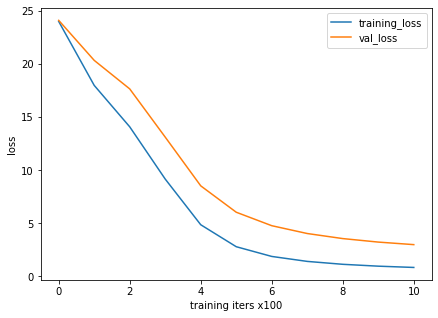

In [13]:
from datetime import datetime

# Apply factorization
U_d = tf.Variable(tf.random.normal((671, 10)))
V_d = tf.Variable(tf.random.normal((10, cutoff)))
 
train_norm = tf.reduce_sum(train_mask)
val_norm = tf.reduce_sum(val_mask)
 
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.002)

start_time = datetime.now()
losses = []
val_losses = []

ep = 0
while True:     
    with tf.GradientTape() as tape:
        M_app = U_d @ V_d
         
        pred_errors_squared = tf.square(M - M_app)
        loss = tf.reduce_sum((train_mask * pred_errors_squared)/train_norm)   
         
    val_loss = tf.reduce_sum((val_mask * pred_errors_squared)/val_norm)
 
    if ep %100 == 0:
        print(datetime.now() - start_time, loss, val_loss, ep)
        losses.append(loss.numpy())
        val_losses.append(val_loss.numpy())
        
    if early_stopping(losses) or ep >= 1000:
        break
     
    grads = tape.gradient(loss, [U_d, V_d])
    adam_opt.apply_gradients(zip(grads, [U_d, V_d]))
 
    ep += 1
 
print("total time: ", datetime.now() - start_time)
print("epochs: ", ep)
 
plt.figure(figsize=(7,5))
plt.plot(losses, label = 'training_loss')
plt.plot(val_losses, label = 'val_loss')
plt.xlabel('training iters x100')
plt.ylabel('loss')
plt.legend()
plt.show()

In [14]:
# Prediction
print(f"U_d {U_d.shape}")
print(f"V_d {V_d.shape}")

test = U_d[0]
test = tf.reshape(test, [1, 10])
print(test @ V_d)

U_d (671, 10)
V_d (10, 9000)
tf.Tensor([[2.1458397 2.507267  2.841413  ... 2.9195228 4.354154  1.7694408]], shape=(1, 9000), dtype=float32)


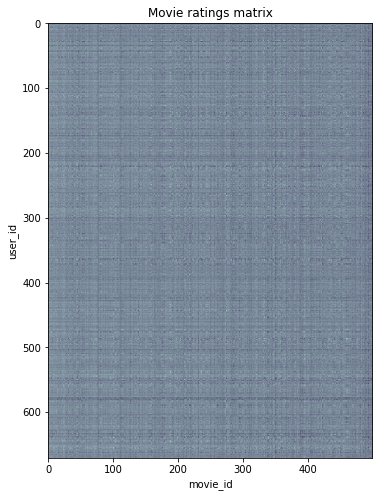

[4.6493945 4.8161736 5.2544503 4.967408  4.3517933 2.1078844 4.4407544
 5.4391875 5.9224887 4.5847216 4.1889296 4.9836917 4.8909163 4.269624
 4.4603357 4.398296  4.1759243 5.1521707 3.4247742 5.1537676 5.467545
 4.4748187 4.851797  5.0161    4.6013002 5.7574267 4.237807  3.4321454
 3.224508  4.752195  3.1100712 3.640546  4.826939  4.047464  4.3698397
 4.1369615 4.619321  3.6063774 1.9901354 4.6644    3.7973192 4.644461
 4.178032  5.242846  5.009039  4.3695393 4.6753836 4.9144497 3.757309
 4.262647  4.035527  2.8790295 3.7049217 3.6076548 4.0945415 3.5735695
 4.7693095 3.3503165 4.1467113 4.207418  5.677252  4.125695  3.4858222
 4.1285324 3.9699562 5.382048  4.2179675 6.2833934 3.5843298 3.8976107
 4.892419  5.4887104 4.368716  4.609402  4.7869363 4.5030785 4.3942313
 3.3118389 2.2250314 3.7283208 3.5369327 4.3132715 4.569539  2.9971924
 3.8479366 4.4642277 4.8098645 3.9726822 3.702718  5.2317348 4.1823225
 4.9432435 3.1396487 3.2590454 4.7961717 5.63158   6.315717  5.0464735
 4.4143996

In [20]:
X = U_d @ V_d

plt.figure(figsize=(10,8))
plt.imshow(X[:,:500], cmap='bone')
plt.xlabel('movie_id')
plt.ylabel('user_id')
plt.title('Movie ratings matrix')
plt.show()
print(X[200].numpy()[:300])